In [1]:
import importlib
import math
import json
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

In [2]:
current_dir = os.getcwd()
base_dir = os.path.dirname(current_dir)
data_dir = os.path.join(base_dir, 'data/processed')

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'supervised_anomaly_detection_results.csv'))

In [4]:
df

,Timestamp,Batch ID,Temperature (°C),pH,Pressure (kPa),Quality Metric (%),Dissolved Oxygen (%),Conductivity (mS/cm),UV Absorbance,RNA Folding Efficiency (%),Nanopore RNA Integrity (Score),Enzyme Concentration (U/mL),Potential_Anomaly,pH_Lag_1,pH_Lag_2,pH_Rolling_Mean,pH_Rolling_Std,Quality_Metric_Rolling_Mean,Quality_Metric_Rolling_Std,Anomaly_Predicted
0,2024-12-08 09:30:00,Batch_001,37.849479,7.509330,102.265556,89.192131,56.715008,14.496277,1.364898,95.333207,7.857872,110.393969,0,7.194705,7.401403,7.352017,0.222473,87.292283,2.686790,0
1,2024-12-08 09:45:00,Batch_001,37.826280,7.477816,101.563845,85.563237,60.153157,14.763025,0.139943,95.998188,8.635882,109.628975,0,7.509330,7.194705,7.493573,0.022284,87.377684,2.566015,0
2,2024-12-08 10:00:00,Batch_001,37.261331,7.297432,100.774389,87.445622,61.257851,14.698342,1.221301,99.639942,8.946542,106.193801,0,7.477816,7.509330,7.387624,0.127550,86.504430,1.331047,0
3,2024-12-08 10:15:00,Batch_001,37.322777,7.431983,99.811039,90.737535,62.384145,15.357686,1.936305,90.418286,8.323373,110.235336,0,7.297432,7.477816,7.364707,0.095142,89.091579,2.327734,0
4,2024-12-08 10:30:00,Batch_001,37.764469,7.444782,100.146733,85.190505,61.477515,15.304527,0.343423,97.870172,9.764178,124.427149,0,7.431983,7.297432,7.438382,0.009051,87.964020,3.922342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-12-09 07:45:00,Batch_003,37.681209,7.515834,101.378554,90.561076,59.244882,14.434512,0.720013,93.046872,7.809654,122.071441,0,7.559943,7.440068,7.537888,0.031190,90.294945,0.376366,0
290,2024-12-09 08:00:00,Batch_003,38.399242,7.357286,101.116423,86.182746,58.981271,15.037926,0.816031,90.793619,8.184243,129.071439,0,7.515834,7.559943,7.436560,0.112110,88.371911,3.095947,0
291,2024-12-09 08:15:00,Batch_003,37.529792,7.348742,102.700948,85.639828,57.848483,13.891028,1.108147,93.570071,7.795571,102.805039,0,7.357286,7.515834,7.353014,0.006042,85.911287,0.383900,0
292,2024-12-09 08:30:00,Batch_003,36.711263,7.399176,101.509033,90.214193,63.947165,15.745305,1.949443,99.425983,9.618155,119.397999,0,7.348742,7.357286,7.373959,0.035662,87.927011,3.234564,0


In [5]:
X = df[[
    "pH", "pH_Lag_1", "pH_Lag_2", "pH_Rolling_Mean", "pH_Rolling_Std",
    "Quality Metric (%)", "Quality_Metric_Rolling_Mean", "Quality_Metric_Rolling_Std"
]]
y = df["Potential_Anomaly"]

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (235, 8)
y_train shape: (235,)


In [7]:
X_train

array([[ 1.50902605, -0.31260723,  0.54961487, ...,  0.65281889,
         0.75340961, -1.16205907],
       [ 0.55160169, -0.37119173,  0.01584446, ..., -0.03927375,
        -0.45457383, -0.18772667],
       [-0.08998649,  0.03651536, -0.60223526, ..., -0.43602744,
         0.19005144,  0.5385967 ],
       ...,
       [-4.9703423 , -5.1028648 , -4.48443641, ..., -5.54148078,
        -4.83190664,  3.06393373],
       [ 0.6996696 ,  1.0267778 ,  0.76310146, ...,  0.13022305,
         0.85622302,  0.53118216],
       [-4.25351578,  0.01350199,  0.20352922, ..., -5.14644299,
        -2.81300248,  6.94015301]])

In [8]:
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(int), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values.astype(int), dtype=torch.long)



In [9]:
class MLP(nn.Module):
  #initialising the model with parameters = Define the layers
    def __init__(
        self, input_dim, hidden_dim, output_dim, is_verbose=False
    ):
        '''
        :param input_dim: input dimension (total number of genes for example)
        :param hidden_dim: hidden dimension (some number)
        :param output_dim: output dimension 
        :param is_verbose: flag indicating whether to print
        '''
        super().__init__()
        #call the parent constructor class
        self.is_verbose = is_verbose

        self.fc_layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.fc_layer2 = nn.Linear(hidden_dim, output_dim)


#--> basically we defined all the puzle pieces above and now we are putting them
#in the correct order
    def forward(self, input: torch.Tensor):
        '''
        :param input: input tensor of shape (batch_size, input_dim)
        :return: return tensor of shape (batch_size, output_dim)
        '''
        x = self.fc_layer1(input)
        x = self.activation(x)
        x = self.fc_layer2(x)
        return x

In [10]:
# Shape
input_size = X_train.shape[1]  # Number of features = how many genes we have
output_size = len(set(y_train))  # Number of classes, for classification = how many cell types we have
print(f"number of features measured are {input_size} and the number of classes are {output_size}, indicating if anomally detected or not")
#Hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001
hidden_size = 64

number of features measured are 8 and the number of classes are 2, indicating if anomally detected or not


In [11]:
model = MLP(input_size, hidden_size, output_size, is_verbose=True)

In [12]:
# Define the loss function and the optimizer
loss_fun = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [13]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [15]:
train_features, train_labels = next(iter(train_loader))
# Sanity check for shape of matrix
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([50, 8])
Labels batch shape: torch.Size([50])


In [16]:
print(model)

MLP(
  (fc_layer1): Linear(in_features=8, out_features=64, bias=True)
  (activation): ReLU()
  (fc_layer2): Linear(in_features=64, out_features=2, bias=True)
)


In [17]:
from sklearn.metrics import accuracy_score, f1_score

In [18]:
def test_model(test_loader):
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  accuracies = []
  f1_scores = []
  f1_scores_macro = []
  f1_scores_micro = []

  errors = []
  batch_losses = []
  eval_batch_losses = []  # List to store batch losses during evaluation
  all_labels = []
  all_predictions = []

  error = 0
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Compute output and loss function
        outputs = model(batch_features)
        loss = loss_fun(outputs, batch_labels)

        eval_batch_losses.append(loss.item())  # Store the batch loss
        print(f"Batch Loss: {loss.item()}")

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        error += loss.item()  # Accumulate the loss value
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

    average_loss = error / len(test_loader)  # Average loss per batch
    errors.append(average_loss)  # Store the average loss
    accuracy = 100 * correct / total  # Calculate accuracy
    accuracies.append(accuracy)  # Store the accuracy
    eval_f1_score = f1_score(all_labels, all_predictions, average='weighted')  # Calculate F1 score
    f1_scores.append(eval_f1_score)

  print(f' Loss: {average_loss}, F1 Score: {eval_f1_score}, Accuracy: {accuracy}%')
  print("Finished Testing.")
  print("======================================================================")

  return model, accuracies, f1_scores

In [19]:
def train_model(train_loader):
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  accuracies = []
  #accuracies_val = []
  f1_scores = []
  f1_scores_macro = []
  f1_scores_micro = []
  epochs = 50
  errors = []
  batch_losses = []
  total = 0
  correct = 0
  error = 0

  for epoch in range(epochs):
    print("\nStarting training ")
    print("======================================================================")
    print(f"Epoch {epoch + 1}")
    error = 0
    model.train()  # Set the model to training mode

    for batch_features, batch_labels in train_loader:

        # Set gradients to zero
        #Zeroing out the gradients after each epoch ensures a clean slate for the next epoch.
        #Helps prevent getting stuck in local minim
        optimizer.zero_grad()

        # Compute output and loss function
        outputs = model(batch_features)
        loss = loss_fun(outputs, batch_labels)

        # Apply backpropagation to output tensor, which will
        # automatically compute gradients of model parameters
        loss.backward()

        # Update model parameters based on computed gradients
        optimizer.step()
        batch_losses.append(loss.item())  # Store the batch loss
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    # Calculate accuracy and F1 score for this batch
        _, predicted = torch.max(outputs.data, 1)
        total = batch_labels.size(0)
        correct = (predicted == batch_labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        f1_sco = f1_score(batch_labels.cpu(), predicted.cpu(), average='weighted')
        f1_scores.append(f1_sco)
        f1_sco_macro = f1_score(batch_labels.cpu(), predicted.cpu(), average='macro')
        f1_scores_macro.append(f1_sco_macro)
        f1_sco_micro = f1_score(batch_labels.cpu(), predicted.cpu(), average='micro')
        f1_scores_micro.append(f1_sco_micro)
        

        print(f'Batch Accuracy: {accuracy:.2f}%, Batch F1 Score: {f1_sco:.4f}')

    model.train()
    
    average_loss = sum(batch_losses) / len(batch_losses)  # Average loss per batch
    errors.append(average_loss)  # Store the average loss

    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}')
    print("Finished training.")
    print("======================================================================")

  # Plot training loss
  plt.plot(range(epochs), errors, marker='o', linestyle='--', color='blue')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Training Loss Over Epochs')
  plt.show()



  # Plotting the loss per batch
  plt.figure(figsize=(20, 6))
  plt.plot(batch_losses, marker='o', linestyle='-', color='black')
  plt.title('Training Loss per Batch')
  plt.xlabel('Batch Number')
  plt.ylabel('Loss')
  for x in range(30, len(batch_losses), 30):
      plt.axvline(x=x, color='red', linestyle='--')

  plt.grid(True)
  plt.show()
  f1_scores_100 = [num * 100 for num in f1_scores]
  print("Accuracies per batch are = ", accuracies)
  print("F1 scores per batch are = ", f1_scores)

# Plot accuracy and F1 score over batches
  plt.figure()
  plt.plot(range(len(accuracies)), accuracies, marker='o', linestyle='--', color='green', label='Accuracy')
  plt.plot(range(len(f1_scores_100)), f1_scores_100, marker='x', linestyle='-', color='red', label='F1 Score')
  plt.xlabel('Batch')
  plt.ylabel('Score')
  plt.title('Batch Accuracy and F1 Score(x100)')
  plt.legend()
  plt.show()

  print("F1 scores macro per batch are = ", f1_scores_macro)
  print("F1 scores micro per batch are = ", f1_scores_micro)

  plt.figure()
  plt.plot(range(len(f1_scores_macro)), f1_scores_macro, marker='o', linestyle='--', color='green', label='F1 Score Macro')
  plt.plot(range(len(f1_scores_micro)), f1_scores_micro, marker='x', linestyle='-', color='red', label='F1 Score Micro')
  plt.plot(range(len(f1_scores)), f1_scores, marker='x', linestyle='-', color='blue', label='F1 Score Weighted')
  # plt.plot(range(len(f1_scores_samples)), f1_scores_samples, marker='x', linestyle='-', color='orange', label='F1 Score Samples')
  plt.xlabel('Batch')
  plt.ylabel('Score')
  plt.title('Different F1 scores')
  plt.legend()



  # Print model parameters
  print('bias for first layer =', model.fc_layer1.bias.data)
  print('bias shape is =', model.fc_layer1.bias.data.shape)
  print('weight for first layer =', model.fc_layer1.weight.data)
  print('weight shape is =', model.fc_layer1.weight.data.shape)
  print("========================================================================")
  print("bias for second layer =", model.fc_layer2.bias.data)
  print('bias shape is =', model.fc_layer2.bias.data.shape)
  print("weight for second layer=", model.fc_layer2.weight.data)
  print('weight shape is =', model.fc_layer2.weight.data.shape)
  return model, errors, accuracies, f1_scores_micro


Starting training 
Epoch 1
Epoch 1, Loss: 0.6559454202651978
Batch Accuracy: 64.00%, Batch F1 Score: 0.7480
Epoch 1, Loss: 0.6949887871742249
Batch Accuracy: 36.00%, Batch F1 Score: 0.4969
Epoch 1, Loss: 0.6719682216644287
Batch Accuracy: 54.00%, Batch F1 Score: 0.6811
Epoch 1, Loss: 0.6422376036643982
Batch Accuracy: 70.00%, Batch F1 Score: 0.7786
Epoch 1, Loss: 0.6596251726150513
Batch Accuracy: 57.14%, Batch F1 Score: 0.7273
Epoch 1/50, Average Loss: 0.6649530410766602
Finished training.

Starting training 
Epoch 2
Epoch 2, Loss: 0.6626821160316467
Batch Accuracy: 70.00%, Batch F1 Score: 0.8071
Epoch 2, Loss: 0.6670824289321899
Batch Accuracy: 54.00%, Batch F1 Score: 0.6732


Epoch 2, Loss: 0.6536859273910522
Batch Accuracy: 56.00%, Batch F1 Score: 0.6522
Epoch 2, Loss: 0.6497276425361633
Batch Accuracy: 64.00%, Batch F1 Score: 0.7805
Epoch 2, Loss: 0.6462723612785339
Batch Accuracy: 65.71%, Batch F1 Score: 0.7673
Epoch 2/50, Average Loss: 0.6604215681552887
Finished training.

Starting training 
Epoch 3
Epoch 3, Loss: 0.6608126759529114
Batch Accuracy: 68.00%, Batch F1 Score: 0.7771
Epoch 3, Loss: 0.6442581415176392
Batch Accuracy: 58.00%, Batch F1 Score: 0.7195
Epoch 3, Loss: 0.6440683007240295
Batch Accuracy: 72.00%, Batch F1 Score: 0.8037
Epoch 3, Loss: 0.6442586779594421
Batch Accuracy: 64.00%, Batch F1 Score: 0.7615
Epoch 3, Loss: 0.6458731889724731
Batch Accuracy: 68.57%, Batch F1 Score: 0.7695
Epoch 3/50, Average Loss: 0.6562324444452922
Finished training.

Starting training 
Epoch 4
Epoch 4, Loss: 0.6291376352310181
Batch Accuracy: 70.00%, Batch F1 Score: 0.7906
Epoch 4, Loss: 0.6621268391609192
Batch Accuracy: 54.00%, Batch F1 Score: 0.6565
Epoch 

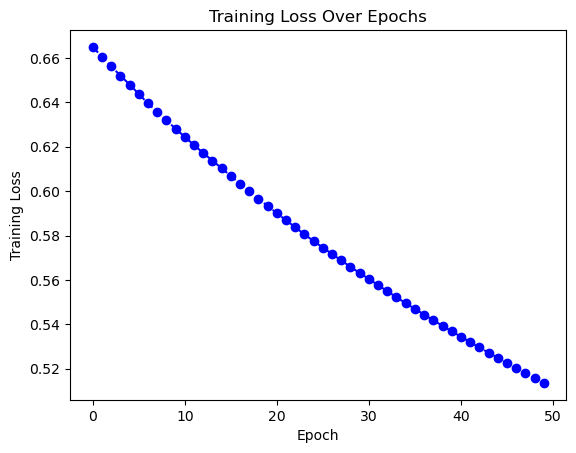

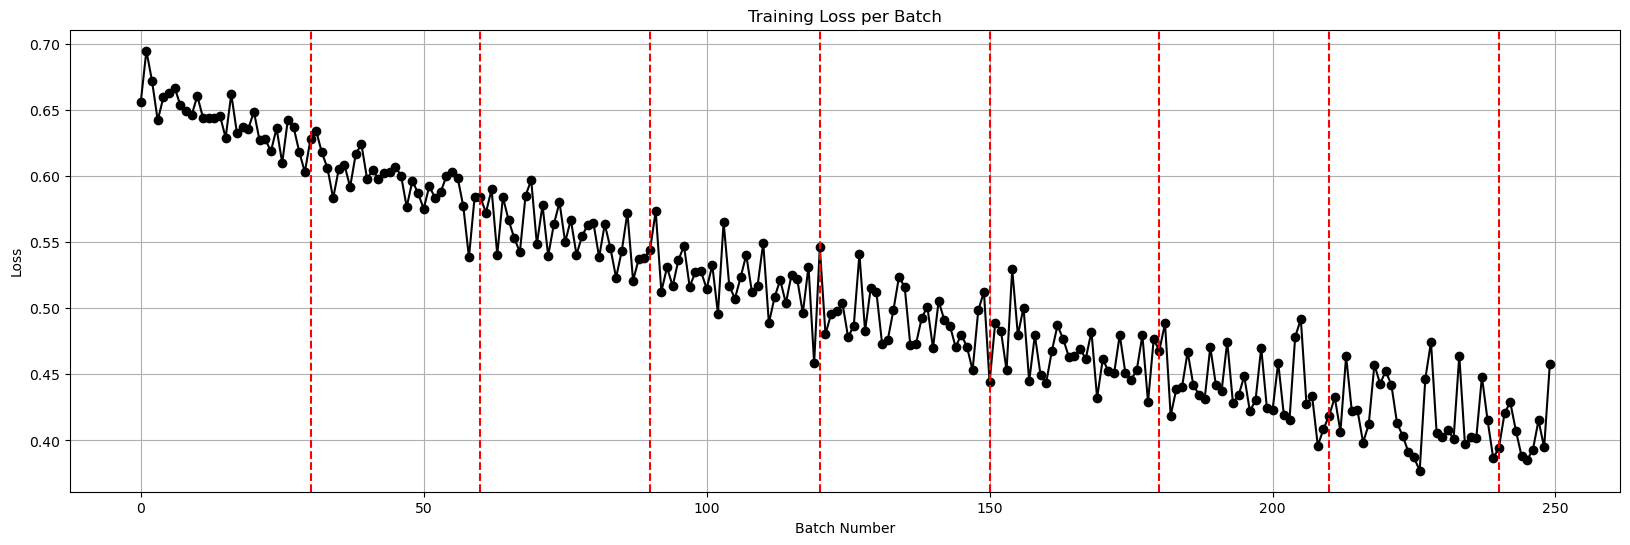

Accuracies per batch are =  [64.0, 36.0, 54.0, 70.0, 57.142857142857146, 70.0, 54.0, 56.0, 64.0, 65.71428571428571, 68.0, 58.0, 72.0, 64.0, 68.57142857142857, 70.0, 54.0, 80.0, 78.0, 74.28571428571429, 72.0, 78.0, 74.0, 74.0, 80.0, 84.0, 74.0, 72.0, 78.0, 85.71428571428571, 82.0, 72.0, 76.0, 80.0, 88.57142857142857, 78.0, 88.0, 82.0, 86.0, 82.85714285714286, 80.0, 90.0, 94.0, 90.0, 85.71428571428571, 90.0, 92.0, 92.0, 90.0, 88.57142857142857, 96.0, 94.0, 92.0, 90.0, 85.71428571428571, 88.0, 92.0, 96.0, 100.0, 94.28571428571429, 96.0, 96.0, 94.0, 96.0, 94.28571428571429, 100.0, 98.0, 100.0, 94.0, 91.42857142857143, 96.0, 96.0, 100.0, 98.0, 94.28571428571429, 98.0, 96.0, 100.0, 96.0, 94.28571428571429, 96.0, 98.0, 94.0, 98.0, 97.14285714285714, 98.0, 92.0, 96.0, 98.0, 100.0, 96.0, 92.0, 98.0, 100.0, 97.14285714285714, 98.0, 96.0, 100.0, 94.0, 94.28571428571429, 98.0, 96.0, 100.0, 94.0, 94.28571428571429, 96.0, 98.0, 96.0, 98.0, 94.28571428571429, 94.0, 100.0, 98.0, 96.0, 94.2857142857142

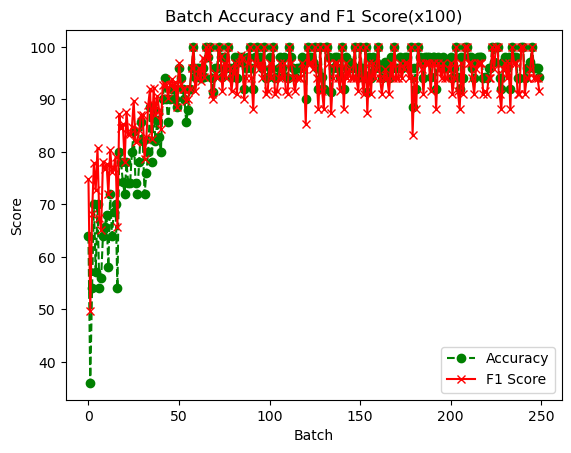

F1 scores macro per batch are =  [np.float64(0.4375), np.float64(0.28698752228163993), np.float64(0.38666666666666666), np.float64(0.5126705653021442), np.float64(0.36363636363636365), np.float64(0.4117647058823529), np.float64(0.35064935064935066), np.float64(0.47619047619047616), np.float64(0.3902439024390244), np.float64(0.4642857142857143), np.float64(0.4579945799457995), np.float64(0.3670886075949367), np.float64(0.4186046511627907), np.float64(0.4375), np.float64(0.5333333333333333), np.float64(0.4117647058823529), np.float64(0.38666666666666666), np.float64(0.5265151515151515), np.float64(0.5137046861184793), np.float64(0.4262295081967213), np.float64(0.5257452574525745), np.float64(0.43820224719101125), np.float64(0.42528735632183906), np.float64(0.42528735632183906), np.float64(0.5537340619307832), np.float64(0.5555555555555556), np.float64(0.49019607843137253), np.float64(0.4186046511627907), np.float64(0.43820224719101125), np.float64(0.46153846153846156), np.float64(0.54034

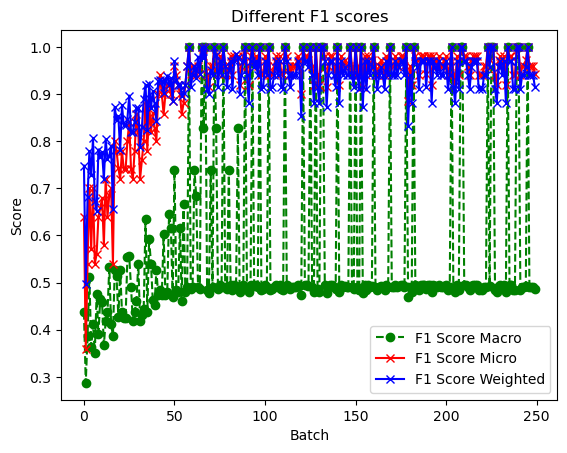

In [20]:
model1, errors1, accuracies1, f1_scores1 = train_model(train_loader)